In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import ALP4

def init_DMD1():
    global DMD1  
    global dmd_res
    global center
    DMD1 = ALP4.ALP4(version = '4.3', libDir = "C:\\Program Files\\ALP-4.3\\ALP-4.3 API")
    # Initialize the device
    DMD1.Initialize(14761) #14761 blue ; 14760 violet
    print(DMD1.DevInquire(2000))
    # Get the resolution of the DMD1
    dmd_res = [DMD1.nSizeY,DMD1.nSizeX]
    center = [DMD1.nSizeY//2,DMD1.nSizeX//2]
init_DMD1()

def init_DMD2():
    global DMD2
    global dmd_res2
    global center2
    DMD2 = ALP4.ALP4(version = '4.3', libDir = "C:\\Program Files\\ALP-4.3\\ALP-4.3 API")
    # Initialize the device
    DMD2.Initialize(14760)
    print(DMD2.DevInquire(2000))
    # Get the resolution of the DMD2                                                                                                                                     
    dmd_res2 = [DMD2.nSizeY,DMD2.nSizeX]
    center2 = [DMD2.nSizeY//2,DMD2.nSizeX//2]
init_DMD2()

Loading library: C:\Program Files\ALP-4.3\ALP-4.3 API/x64/alp4395.dll
DMD found, resolution = 1024 x 768.
14761
Loading library: C:\Program Files\ALP-4.3\ALP-4.3 API/x64/alp4395.dll
DMD found, resolution = 1024 x 768.
14760


## SETUP DAQ for AO if needed

In [3]:
from mcculw.device_info import DaqDeviceInfo
from mcculw import ul
from mcculw.enums import TimerIdleState, FunctionType, Status, ULRange, DigitalPortType
from mcculw.device_info import DaqDeviceInfo
from mcculw.enums import ScanOptions, ChannelType, ULRange, DigitalPortType, DigitalIODirection
from mcculw import ul
import numpy as npA
from ctypes import cast, POINTER, c_double, c_ushort, c_ulong
import time

DAQ_Active=1

def DAQ():
    DAQRate = 1000
    
    experDuration = 1000
    
    ## Create Signals for Analog Output
    AO1_Active = 1
    AO2_Active = 1
    
    
    AO1_Data = 0.081*np.ones(DAQRate*experDuration) #0.47
    AO2_Data = 0.150*np.ones(DAQRate*experDuration)
    
    ## MAKE ALL SIGNALS SAME LENGTH
    ## Make all output waveforms have the same numbers of points
    OutputLengths = []
    if (AO1_Active):
        OutputLengths.append(len(AO1_Data))
    if (AO2_Active):
        OutputLengths.append(len(AO2_Data))
        
    longestOutput = max(OutputLengths)
    
    if (AO1_Active):
        DataAO1 = np.pad(AO1_Data, (0, (longestOutput-(len(AO1_Data)))), 'constant')
    if (AO2_Active):
        DataAO2 = np.pad(AO2_Data, (0, (longestOutput-(len(AO2_Data)))), 'constant')
    
    # Create data for inactive outputs
    if (AO1_Active == 0):
        DataAO1 = np.zeros(longestOutput)
    if (AO2_Active == 0):
        DataAO2 = np.zeros(longestOutput)
    
    
    ###########################
    ## Initiate
    board_num = 0
    daq_dev_info = DaqDeviceInfo(board_num = 0)
    
    ## Setup Digital Output
    ## Determine Experiment Duration
    Exp_Duration = longestOutput/DAQRate
    
    ##### Set DAQ Outputs to Zero 
    #Analog
    ul.v_out(0, 0, ULRange.BIP10VOLTS, 0)
    ul.v_out(0, 1, ULRange.BIP10VOLTS, 3.3)
    
    #Stop clock pulse
    ul.pulse_out_stop(0, 0)
    
    ###########################
    ##### Setup Analog Output
    chan_list = []
    chan_type_list = []
    gain_list = []
    num_chans = 0
    device_info = DaqDeviceInfo(board_num)
    ao_info = device_info.get_ao_info()
    
    ## Analog Output 1
    chan_list.append(0)
    chan_type_list.append(ChannelType.ANALOG)
    gain_list.append(ao_info.supported_ranges[0])
    num_chans += 1
    
    ## Analog Output 2
    chan_list.append(1)
    chan_type_list.append(ChannelType.ANALOG)
    gain_list.append(ao_info.supported_ranges[0])
    num_chans += 1
        
        
    ## Create the output data buffer
    num_points = int (num_chans*DAQRate*Exp_Duration)
    memhandle_O = ul.win_buf_alloc(num_points)
    if not memhandle_O:
        raise Exception('Error: Failed to allocate memory')
    data_array = cast(memhandle_O, POINTER(c_ushort))
    
    
    ## Load the data into the buffer (for both AO and DO)
    ao_range = ao_info.supported_ranges[0]
    data_index = 0
    for i in range(int (DAQRate*Exp_Duration)):
        #AO1
        raw_value = ul.from_eng_units(board_num, ao_range, DataAO1[i])
        data_array[data_index] = raw_value
        data_index += 1
        #AO2
        raw_value = ul.from_eng_units(board_num, ao_range, DataAO2[i])
        data_array[data_index] = raw_value
        data_index += 1
        
    ## Initiate the DAQ for AO
    scan_options = ScanOptions.BACKGROUND | ScanOptions.EXTCLOCK
    ul.daq_out_scan(board_num, chan_list, chan_type_list, gain_list, num_chans, DAQRate, num_points,
                                memhandle_O, scan_options)
    ## SETUP DAQ FOR ANALOG INPUT
    ## Set the scan options
    scan_options_AI = ScanOptions.BACKGROUND | ScanOptions.EXTCLOCK
    ## Allocate a buffer for the input
    memhandle_AI = ul.win_buf_alloc(int (DAQRate*Exp_Duration))
    if not memhandle_AI:
        raise Exception('Error: Failed to allocate memory')
    
    ## Convert the memhandle to a ctypes array
    ctypes_array_AI = cast(memhandle_AI, POINTER(c_ushort))
    
    ## Analog Input
    ul.a_in_scan(0, 0, 0, (int (DAQRate*Exp_Duration)), DAQRate, ULRange.BIP2PT5VOLTS, memhandle_AI, scan_options_AI)

    #Start clock pulse (to clock ADCs and DACs of DAQ)
    ul.pulse_out_start(0, 0, DAQRate, 0.5, pulse_count=(int (DAQRate*Exp_Duration)), initial_delay=1, idle_state=TimerIdleState.LOW)
    
    time.sleep(2)
if DAQ_Active == 1:
    DAQ()


In [4]:
# import numpy as np
# import time

# DMD = DMD1

# bitDepth = 9
# dmd_res = [DMD.nSizeY, DMD.nSizeX]  # [rows, cols]
# dmd_center = [dmd_res[0] // 2, dmd_res[1] // 2]
# x = np.linspace(0, dmd_res[1], dmd_res[1])
# n = 5  # number of lines (intensity steps)
# rows, cols = n * 2 + 1, n * 2 + 1
# rect_width = 22
# rect_heigth = 22
# maxI = 2**bitDepth - 1
# I = np.linspace(maxI, 55, n).astype(np.uint8)
# image = np.zeros((dmd_res[0], dmd_res[1]), dtype=np.uint8)
# # --- Offset 
# square_size = 250
# x_right_offset = 277
# y_bottom_offset = 250
# x_offset = dmd_res[1] - x_right_offset - square_size
# y_offset = dmd_res[0] - y_bottom_offset - square_size
# for c in range(cols):
#     C = c // 2  # index intensité
#     for r in range(rows):
#         if c % 2 == 1:  # colonnes impaires
#             x1 = y_offset + r * rect_heigth
#             y1 = x_offset + c * rect_width
#             if x1 + rect_heigth < dmd_res[0] and y1 + rect_width < dmd_res[1]:
#                 image[int(x1):int(x1+rect_heigth), int(y1):int(y1+rect_width)] = I[C]


# plt.imshow(image, cmap="gray", vmin=0, vmax=255)
# plt.plot(center[1], center[0], "r+")
# plt.title("DMD pattern with offset")
# plt.xlabel("x pixels")
# plt.ylabel("y pixels")
# plt.show()
# plt.figure()
# plt.plot(x, image[dmd_res[0] -500, :])
# plt.xlabel("x pixels")
# plt.ylabel("Intensity (8bit)")
# plt.title("Intensity lines pattern")
# plt.show()



In [5]:
# import ctypes as ct
# imgSeq = np.tile(image.ravel(), 10)
# DMD.SeqAlloc(nbImg=10, bitDepth=1)
# DMD.SeqPut(imgData=imgSeq)
# DMD.SeqControl(2107,6)
# DMD.SeqControl(ALP4.ALP_FLUT_ENTRIES9,2 * 10)

# flut_data = ALP4.tFlutWrite()
# flut_data.nOffset = 0           # Start offset for the LUT
# flut_data.nSize = 2 * 10   # Set the size to twice the number of frames

# flut_data.FrameNumbers[0] = 0
# flut_data.FrameNumbers[1] = 5
# flut_data.FrameNumbers[2] = 1
# flut_data.FrameNumbers[3] = 6
# flut_data.FrameNumbers[4] = 2
# flut_data.FrameNumbers[5] = 7
# flut_data.FrameNumbers[6] = 3
# flut_data.FrameNumbers[7] = 8
# flut_data.FrameNumbers[8] = 4
# flut_data.FrameNumbers[9] = 9

# print(f"Control Type: {2325}")
# print(f"nOffset: {flut_data.nOffset}, nSize: {flut_data.nSize}")
# print(f"FrameNumbers: {list(flut_data.FrameNumbers[:flut_data.nSize])}")


# return_value = DMD._ALPLib.AlpProjControl(DMD.ALP_ID, 2325, ct.byref(flut_data))
# print(f"Return Value: {return_value}")

# flut_pointer = ct.pointer(flut_data)
# DMD.ProjControlEx(2325,ct.byref(flut_data))






In [6]:
# print(ALP4.ALP_FLUT_MODE)

In [7]:
# DMD.SetTiming(pictureTime=int((1)*10**6))  # 5ms par image (200 Hz)
# DMD.SeqAlloc(nbImg=nb_frame, bitDepth=bitDepth)
# DMD.SeqPut(imgData=imgSeq)

# DMD.Run()
# time.sleep(ExpDuration)
# DMD.Halt()
# DMD.FreeSeq()
# DMD.Free()

## SETUP DMD

## PATTERN 1

In [10]:
def pattern1(DMD, nb_frame, frameTime, bitD, ExpDuration):
    bitDepth = bitD
    dmd_res = [DMD.nSizeY,DMD.nSizeX]
    dmd_center = [dmd_res[0]//2,dmd_res[1]//2]
    #number, size, intensity (cst) of lines
    n_frames=nb_frame
    x=np.linspace(0,dmd_res[1], dmd_res[1])
    n=5 #number of lines
    rows, cols = n*2+1 ,n*2+1
    rect_width = 46
    rect_heigth = 46
    n_cols=np.linspace(0,n,1)
    maxI=2**bitDepth-1
    I=np.linspace(maxI,55,n) #intensity choice
    print("I=",I)
    image = np.zeros((dmd_res[0],dmd_res[1]), dtype=np.uint8) #fond
    for c in range(cols):
        C=c//2
        for r in range(rows):
            if c%2 == 1: #colonnes impaires
                x_offset=int(dmd_res[0]/2)-int(rows*rect_width/2)
                y_offset=int(dmd_res[1]/2)-int(cols*rect_heigth/2)
                x1=x_offset+r*rect_heigth
                y1=y_offset+c*rect_width
                image[int(x1):int(x1+rect_heigth), int(y1):int(y1+rect_width)] = I[C]
    
    plt.imshow(image, cmap="gray", vmin=0, vmax=255)
    plt.plot(dmd_center[1],dmd_center[0],"r+")
    plt.title("DMD pattern")
    plt.xlabel("x pixels")
    plt.ylabel("y pixels")
    plt.show()
    plt.figure()
    
    plt.plot(x,image[dmd_res[0] // 2, :])
    plt.xlabel("x pixels")
    plt.ylabel("Intensity (8bit)")
    plt.title("Intensity lines pattern")
    plt.show()
    
    # Allocate the onboard memory for the image sequence
    DMD.SeqAlloc(nbImg = 1, bitDepth = bitDepth)
    DMD.SeqPut(imgData = image.ravel()) # Send the image sequence as a 1D list/array/numpy array
    DMD.SetTiming(pictureTime = frameTime)
    #DMD.ProjControl(2300, 2302)
    DMD.Run() # Run the sequence in an infinite loop
    time.sleep(ExpDuration)
    DMD.Halt() # Stop the sequence display
    DMD.FreeSeq() # Free the sequence from the onboard memory
    DMD.Free() # De-allocate the device

## PATTERN 2

In [12]:
def pattern2(DMD, nb_frame, sinfreq, bitD, ExpDuration):
    dmd_res = [DMD.nSizeY,DMD.nSizeX]
    # nxN square pattern
    bitDepth = bitD
    imgTab=[]
    #number, size, intensity of squares 
    n=3
    rows, cols = n*2+1 ,n*2+1
    rect_width = 46
    rect_heigth = 46
    f=sinfreq
    T=1/f
    I_max=255
    n_frames=nb_frame
    dt=T/n_frames
    t=np.linspace(0,T,n_frames)
    for frame in range(n_frames):
        image = np.zeros((dmd_res[0],dmd_res[1]), dtype=np.uint8) #fond
        I = int((I_max / 2) * (1 + np.sin(2 * np.pi * f * t[frame])))
        for r in range(rows):
            for c in range(cols):
                if r%2 == 1 and c%2 == 1:
                    x_offset=int(dmd_res[0]/2)-int(rows*rect_width/2)
                    y_offset=int(dmd_res[1]/2)-int(cols*rect_heigth/2)
                    x1=x_offset+r*rect_heigth
                    y1=y_offset+c*rect_width
                    image[int(x1):int(x1+rect_heigth), int(y1):int(y1+rect_width)] = I
        imagecopy=image.copy()
        imgTab.append(imagecopy.ravel())
    I_values = (I_max / 2) * (1 + np.sin(2 * np.pi * f * t))
    plt.imshow(image, cmap="gray")
    plt.plot(dmd_res[1]/2,dmd_res[0]/2,"r+")
    plt.title("DMD pattern")
    plt.show()
    plt.figure()
    plt.plot(range(n_frames), I_values)
    plt.xlabel("frames")
    plt.ylabel("Intensity (0-255)")
    plt.title("sin intensity")
    plt.grid(True)
    plt.show()
    print(f"sin freq={f}Hz")
    print(f"dt={dt*10**6}ms")
    
    imgSeq  = np.concatenate(imgTab)
    
    # Allocate the onboard memory for the image sequence
    DMD.SeqAlloc(nbImg = n_frames, bitDepth = bitDepth)
    # Send the image sequence as a 1D list/array/numpy array
    DMD.SeqPut(imgData = imgSeq)
    DMD.SetTiming(pictureTime = int(dt*5e5)) 
    #DMD.ProjControl(2300, 2302)
    DMD.Run() # Run the sequence in an infinite loop
    time.sleep(ExpDuration)
    DMD.Halt() # Stop the sequence display
    DMD.FreeSeq() # Free the sequence from the onboard memory
    DMD.Free() # De-allocate the device

## PATTERN 3

Min pixel: 0 Max pixel: 255


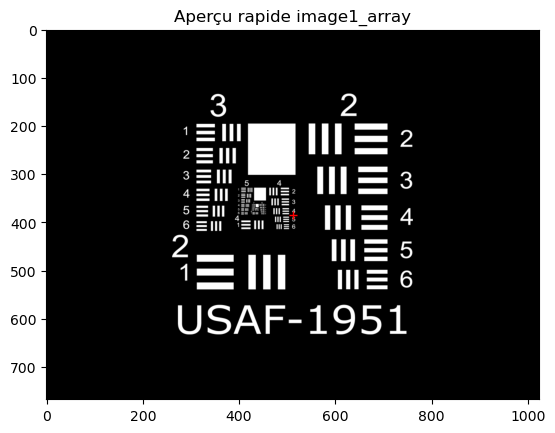

In [14]:
import io
from PIL import Image
from matplotlib.patches import Rectangle
import cairosvg
from PIL import ImageOps

png_data = "C:/Users/Algoscope/Pictures/USAF6000.png"

def pattern3(DMD, nb_frame, bitD, ExpDuration):
    bitDepth = bitD
    n_frames=nb_frame
    # Define DMD resolution
    dmd_res = (DMD.nSizeY, DMD.nSizeX) 
    x_center = (dmd_res[1] - 500) // 2
    y_center = (dmd_res[0] - 500) // 2
    
    # Load two monochrome (black and white) images
    motif = Image.open(png_data).convert("L").resize((500, 500))
    #motif = ImageOps.invert(motif) 
    
    
    image1 = Image.new("L", (dmd_res[1], dmd_res[0]), color=0)
    image2 = Image.new("L", (dmd_res[1], dmd_res[0]), color=0)
    
    image1.paste(motif, (x_center, y_center))
    image2.paste(motif, (x_center, y_center))
    
    # Convert to numpy arrays and ensure 8-bit unsigned int type
    image1_array = np.array(image1, dtype=np.uint8)
    image2_array = np.array(image2, dtype=np.uint8)
    
    # Flatten and concatenate images into a single sequence
    imgSeq = np.concatenate([image1_array.ravel(), image2_array.ravel()])
    # Allocate onboard memory for 2 images
    DMD.SeqAlloc(nbImg=2, bitDepth=bitDepth)
    DMD.SeqPut(imgData=imgSeq) # Send the sequence to the DMD
    DMD.SetTiming(pictureTime=int((1/200)*10**6))
    #DMD.ProjControl(2300, 2302)
    DMD.Run()
    time.sleep(ExpDuration)
    DMD.Halt() # Stop the sequence display
    DMD.FreeSeq() # Free the sequence from the onboard memory
    DMD.Free() # De-allocate the device
    return image1_array, image2_array

#visualisation
motif = Image.open(png_data).convert("L").resize((500, 500))
motif = ImageOps.invert(motif) 


image1 = Image.new("L", (dmd_res[1], dmd_res[0]), color=0)
image2 = Image.new("L", (dmd_res[1], dmd_res[0]), color=0)
x_center = (dmd_res[1] - 500) // 2
y_center = (dmd_res[0] - 500) // 2
image1.paste(motif, (x_center, y_center))
image2.paste(motif, (x_center, y_center))
# Convert to numpy arrays and ensure 8-bit unsigned int type
image1_array = np.array(image1, dtype=np.uint8)
image2_array = np.array(image2, dtype=np.uint8)
print("Min pixel:", image1_array.min(), "Max pixel:", image1_array.max())
plt.imshow(image1_array, cmap='gray')
plt.title("Aperçu rapide image1_array")

plt.plot(dmd_res[1]// 2, dmd_res[0]// 2, "r+")
plt.show()


## PATTERN 4

[768, 1024]


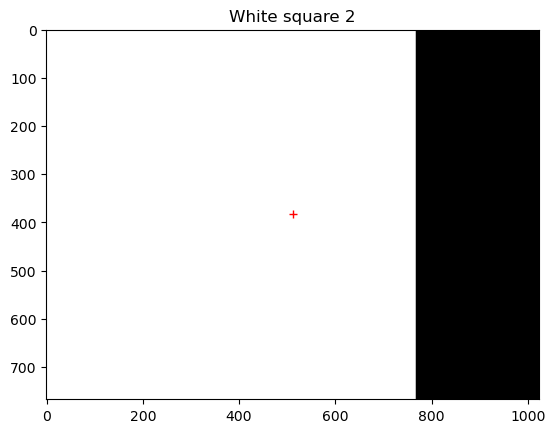

In [16]:
import numpy as np
import time

def pattern4(DMD, nb_frame, bitD, ExpDuration):
    bitDepth = bitD
    dmd_res = (DMD.nSizeY, DMD.nSizeX)
    
    # Calcul des coordonnées du carré
    square_size = 437
    #x_right_offset = int(dmd_res[1]/2)
    #y_bottom_offset = int(dmd_res[0]/2)
    
    x_start = (dmd_res[1] - square_size) // 2 +100 # colonne de départ
    y_start = (dmd_res[0] - square_size) // 2 +100  # ligne de départ

    # Créer deux images noires
    image1_array = np.zeros(dmd_res, dtype=np.uint8)
    image2_array = np.zeros(dmd_res, dtype=np.uint8)

    # Dessiner le carré blanc (valeur 255)
    image1_array[:,:] = 0
    image2_array[:,:] = 0
    image1_array[y_start:y_start+square_size, x_start:x_start+square_size] = 255
    image2_array[y_start:y_start+square_size, x_start:x_start+square_size] = 1
    # Répéter l’image autant de fois que nécessaire
    imgSeq = np.tile(image1_array.ravel(), nb_frame)
    #imgSeq = np.concatenate([image1_array.ravel(),image2_array.ravel()])
    # Allocation mémoire et envoi des images
    DMD.SeqAlloc(nbImg=nb_frame, bitDepth=bitDepth)
    DMD.SeqPut(imgData=imgSeq)
    DMD.SetTiming(pictureTime=int((1/200)*10**6))  # 5ms par image (200 Hz)

    # Lancer la séquence
    DMD.Run()
    time.sleep(ExpDuration)

    # Nettoyage
    DMD.Halt()
    DMD.FreeSeq()
    DMD.Free()

square_size = 437
x_right_offset = int(dmd_res[1]/2)  #208
y_bottom_offset = int(dmd_res[0]/2) #165

x_start = (dmd_res[1] - square_size) // 2  # colonne de départ
y_start = (dmd_res[0] - square_size) // 2  # ligne de départ

# Créer deux images noires
image1_array = np.zeros(dmd_res, dtype=np.uint8)

# Dessiner le carré blanc (valeur 255)
#image1_array[y_start:y_start+square_size, x_start:x_start+square_size] = 255
image1_array[0:dmd_res[1], 0:dmd_res[0]] = 255
print(dmd_res)

plt.imshow(image1_array, cmap='gray')
plt.title("White square 2")
center_x = x_start + square_size // 2
center_y = y_start + square_size // 2
plt.plot(center_x, center_y, "r+")
plt.show()

## PATTERN 5

[768, 1024]


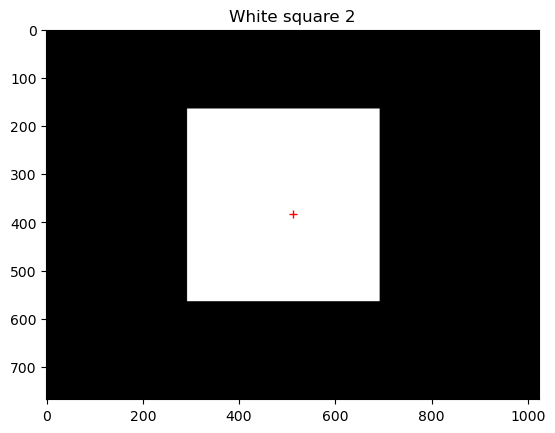

In [18]:
### import numpy as np
# import time

# def pattern5(DMD, nb_frame, bitD, ExpDuration):
#     bitDepth = bitD
#     dmd_res = (DMD.nSizeY, DMD.nSizeX)
    
#     # Calcul des coordonnées du carré
#     square_size = 437
#     x_right_offset = 200 #180
#     y_bottom_offset = 100
    
#     x_start = dmd_res[1] - x_right_offset - square_size  # col
#     y_start = dmd_res[0] - y_bottom_offset - square_size  # row

#     # Créer deux images noires
#     image1_array = np.zeros(dmd_res, dtype=np.uint8)
#     image2_array = np.zeros(dmd_res, dtype=np.uint8)

#     # Dessiner le carré blanc (valeur 255)
#     image1_array[y_start:y_start+square_size, x_start:x_start+square_size] = 255
#     image2_array[y_start:y_start+square_size, x_start:x_start+square_size] = 255

#     # Répéter l’image autant de fois que nécessaire
#     imgSeq = np.tile(image1_array.ravel(), nb_frame)

#     # Allocation mémoire et envoi des images
#     DMD.SeqAlloc(nbImg=nb_frame, bitDepth=bitDepth)
#     DMD.SeqPut(imgData=imgSeq)
#     DMD.SetTiming(pictureTime=int((1/200)*10**6))  # 5ms par image (200 Hz)

#     # Lancer la séquence
#     DMD.Run()
#     time.sleep(ExpDuration)

#     # Nettoyage
#     DMD.Halt()
#     DMD.FreeSeq()
#     DMD.Free()

# square_size = 437
# x_right_offset = 200
# y_bottom_offset = 250

# x_start = dmd_res[1] - x_right_offset - square_size  # col
# y_start = dmd_res[0] - y_bottom_offset - square_size  # row

# # Créer deux images noires
# image1_array = np.zeros(dmd_res, dtype=np.uint8)

# # Dessiner le carré blanc (valeur 255)
# image1_array[y_start:y_start+square_size, x_start:x_start+square_size] = 255

# plt.imshow(image1_array, cmap='gray')
# plt.title("White square 2")
# plt.show()

import numpy as np
import time

def pattern5(DMD, nb_frame, bitD, ExpDuration):
    bitDepth = 8
    dmd_res = (DMD.nSizeY, DMD.nSizeX)
    
    # Calcul des coordonnées du carré
    square_size = 437
    #x_right_offset = int(dmd_res[1]/2)
    #y_bottom_offset = int(dmd_res[0]/2)
    
    x_start = (dmd_res[1] - square_size) // 2 +360  # colonne de départ
    y_start = (dmd_res[0] - square_size) // 2  +100 # ligne de départ

    # Créer deux images noires
    image1_array = np.zeros(dmd_res)
    image2_array = np.zeros(dmd_res)

    # Dessiner le carré blanc (valeur 255)
    image1_array[:,:] = 0
    image2_array[:,:] = 0
    image1_array[y_start:y_start+400, x_start:x_start+400] = 255
    image2_array[y_start:y_start+400, x_start:x_start+400] = 1
    # Répéter l’image autant de fois que nécessaire
    imgSeq = np.tile(image1_array.ravel(), nb_frame)
    #imgSeq = np.concatenate([image1_array.ravel(),image2_array.ravel()])
    # Allocation mémoire et envoi des images
    DMD.SeqAlloc(nbImg=nb_frame, bitDepth=bitDepth)
    DMD.SeqPut(imgData=imgSeq)
    DMD.SetTiming(pictureTime=int((1/200)*10**6))  # 5ms par image (200 Hz)

    # Lancer la séquence
    DMD.Run()
    time.sleep(ExpDuration)

    # Nettoyage
    DMD.Halt()
    DMD.FreeSeq()
    DMD.Free()

square_size = 437
x_right_offset = int(dmd_res[1]/2)  #208
y_bottom_offset = int(dmd_res[0]/2) #165

x_start = (dmd_res[1] - square_size) // 2  # colonne de départ
y_start = (dmd_res[0] - square_size) // 2  # ligne de départ

# Créer deux images noires
image1_array = np.zeros(dmd_res, dtype=np.uint8)

# Dessiner le carré blanc (valeur 255)
#image1_array[y_start:y_start+square_size, x_start:x_start+square_size] = 255
image1_array[0:dmd_res[1], 0:dmd_res[0]] = 0
image1_array[y_start:y_start+400, x_start:x_start+400] = 255

print(dmd_res)

plt.imshow(image1_array, cmap='gray')
plt.title("White square 2")
center_x = x_start + square_size // 2
center_y = y_start + square_size // 2
plt.plot(center_x, center_y, "r+")
plt.show()

## PATTERN 6

255
I = [255. 255. 255. 255. 255. 255.]


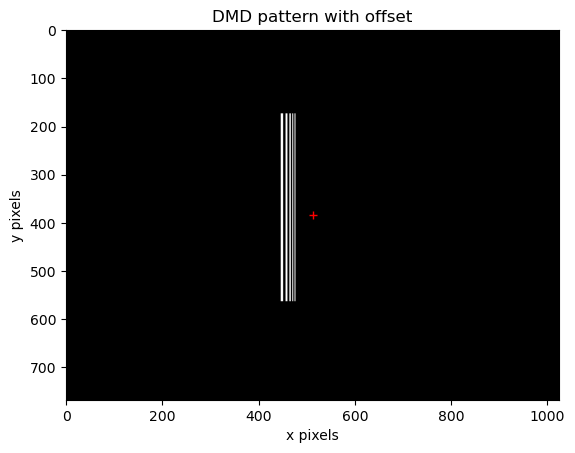

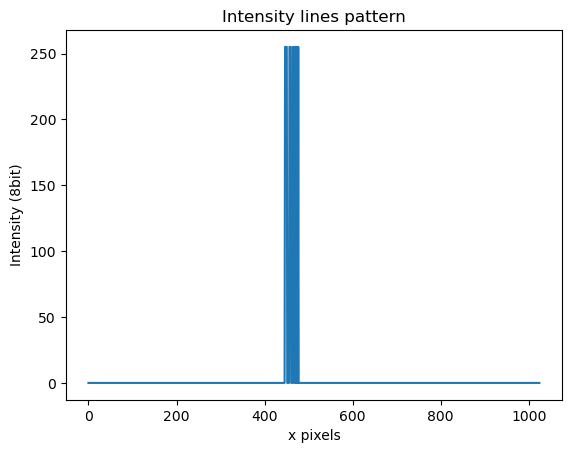

In [20]:
import numpy as np
import time

def pattern6(DMD, nb_frame, bitD, ExpDuration):
    bitDepth = bitD
    dmd_res = [DMD.nSizeY, DMD.nSizeX]  # [rows, cols]
    dmd_center = [dmd_res[0] // 2, dmd_res[1] // 2]
    x = np.linspace(0, dmd_res[1], dmd_res[1])
    n = 20 # number of lines (intensity steps)
    rows, cols = n * 2 + 1, n * 2 + 1
    # l=152
    # d=0.167*l
    # rect_width = d*np.ones(n)
    start = n
    l = [2 * i for i in range(start, 0, -1)] 
    d = list(range(start, 0, -1)) # largeur des rectangles (lignes)
    rect_width = d
    rect_heigth = 5*np.ones(n)
    maxI = 2**bitDepth - 1
    print(maxI)
    I= 255*np.ones(n)
    #I = np.linspace(maxI, 55, n).astype(np.uint8)
    print("I =", I)
    # Image noire de base
    image = np.zeros((dmd_res[0], dmd_res[1]), dtype=np.uint8)
    # --- Offset comme pour le carré ---
    square_size = 437
    # x_right_offset = 207
    # y_bottom_offset = 150
    # x_start = dmd_res[1] - x_right_offset - square_size
    # y_start = dmd_res[0] - y_bottom_offset - square_size
    x_start = (dmd_res[1] - square_size) // 2 + 400
    
    # colonne de départ
    y_start = (dmd_res[0] - square_size) // 2 +57  # ligne de départ
    num_lines = cols // 2
    rect_w = rect_width[0]  # assuming all widths are the same
    rect_h = rect_heigth[0]
    total_line_width = sum(rect_width) + sum(l[:-1])  # On ne met pas d'espace après la dernière
    x_offset_lines = x_start + (437 - total_line_width) // 2 #centrage
    y_offset_lines = y_start + (437 - rows*rect_h) // 2 #centrage

    for c in range(cols):
        C = c // 2  # index intensité
        for r in range(rows):
            if c % 2  == 1:  # colonnes impaires
                x1 = y_offset_lines + r * rect_h
                y1 = x_offset_lines + sum(l[:C])
                if x1 + rect_heigth[C] < dmd_res[0] and y1 + rect_width[C] < dmd_res[1]:
                    image[int(x1):int(x1+rect_heigth[C]), int(y1):int(y1+rect_width[C])] = I[C]

                
    imgSeq = np.tile(image.ravel(), nb_frame)
    
    DMD.SeqAlloc(nbImg=nb_frame, bitDepth=bitDepth)
    DMD.SeqPut(imgData=imgSeq)
    DMD.SetTiming(pictureTime=int((1/200)*10**6))  # 5ms par image (200 Hz)
    DMD.Run()
    time.sleep(ExpDuration)
    DMD.Halt()
    DMD.FreeSeq()
    DMD.Free()


# --- Visualisation ---
bitDepth=8
x = np.linspace(0, dmd_res[1], dmd_res[1])
n = 6  # number of lines (intensity steps)
rows, cols = n * 2 + 1, n * 2 + 1
l=[10,8,6,4,2,2]
d=[5,4,3,2,1,1]
rect_width = d
rect_heigth = 30*np.ones(n)
maxI = 2**bitDepth - 1
print(maxI)
I= 255*np.ones(n)
#I = np.linspace(maxI, 55, n).astype(np.uint8)
print("I =", I)
# Image noire de base
image = np.zeros((dmd_res[0], dmd_res[1]), dtype=np.uint8)
# --- Offset comme pour le carré ---
square_size = 300
x_right_offset = 350
y_bottom_offset = 250
x_start = dmd_res[1] - x_right_offset - square_size
y_start = dmd_res[0] - y_bottom_offset - square_size
num_lines = cols // 2
rect_w = rect_width[0]  # assuming all widths are the same
rect_h = rect_heigth[0]
total_line_width = sum(l[:num_lines - 1]) + rect_w
x_offset_lines = x_start + (square_size - total_line_width) // 2 -60 #centrage
y_offset_lines = y_start + (square_size - rows*rect_h) // 2 #centrage
for c in range(cols):
    C = c // 2
    for r in range(rows):
        if c % 2 == 1:
            x1 = y_offset_lines + r * rect_h
            y1 = x_offset_lines + sum(l[:C])  # Somme des largeurs précédentes
            if x1 + rect_heigth[C] < dmd_res[0] and y1 + rect_width[C] < dmd_res[1]:
                image[int(x1):int(x1+rect_heigth[C]), int(y1):int(y1+rect_width[C])] = I[C]
plt.imshow(image, cmap="gray", vmin=0, vmax=255)
plt.plot(center[1], center[0], "r+")
plt.title("DMD pattern with offset")
plt.xlabel("x pixels")
plt.ylabel("y pixels")
plt.show()
plt.figure()
plt.plot(x, image[dmd_res[0] -500, :])
plt.xlabel("x pixels")
plt.ylabel("Intensity (8bit)")
plt.title("Intensity lines pattern")
plt.show()

In [21]:
def pattern6_horizontal(DMD, nb_frame, bitD, ExpDuration):
    import numpy as np
    
    bitDepth = bitD
    dmd_res = [DMD.nSizeY, DMD.nSizeX]  # [rows, cols]
    dmd_center = [dmd_res[0] // 2, dmd_res[1] // 2]
    x = np.linspace(0, dmd_res[1], dmd_res[1])
    
    n = 20  # number of intensity steps
    rows, cols = n * 2 + 1, n * 2 + 1
    
    start = n
    l = [2 * i for i in range(start, 0, -1)]  # Espacement entre les lignes (hauteur des vides)
    d = list(range(start, 0, -1))            # Hauteur des bandes horizontales
    rect_height = d
    rect_width = 5 * np.ones(n)              # Largeur constante des bandes
    
    maxI = 2**bitDepth - 1
    I = 255 * np.ones(n, dtype=np.uint8)     # Intensités constantes (peut être modifié)
    
    # Image noire de base
    image = np.zeros((dmd_res[0], dmd_res[1]), dtype=np.uint8)
    
    # Paramètres pour centrage
    square_size = 437
    x_start = (dmd_res[1] - square_size) // 2 + 150
    y_start = (dmd_res[0] - square_size) // 2 + 100

    num_lines = rows // 2
    rect_h = rect_height[0]
    rect_w = rect_width[0]
    
    total_line_height = sum(rect_height) + sum(l[:-1])
    y_offset_lines = y_start + (437 - total_line_height) // 2
    x_offset_lines = x_start + (437 - cols * rect_w) // 2

    # --- DESSIN DES LIGNES HORIZONTALES ---
    for r in range(rows):
        R = r // 2  # index intensité
        for c in range(cols):
            if r % 2 == 1:  # lignes impaires = lignes avec intensité
                y1 = y_offset_lines + sum(l[:R])  # position verticale (ligne)
                x1 = x_offset_lines + c * rect_w  # position horizontale (colonne)
                if y1 + rect_height[R] < dmd_res[0] and x1 + rect_width[R] < dmd_res[1]:
                    image[int(y1):int(y1 + rect_height[R]), int(x1):int(x1 + rect_width[R])] = I[R]
    imgSeq = np.tile(image.ravel(), nb_frame)
    
    DMD.SeqAlloc(nbImg=nb_frame, bitDepth=bitDepth)
    DMD.SeqPut(imgData=imgSeq)
    DMD.SetTiming(pictureTime=int((1/200)*10**6))  # 5ms par image (200 Hz)
    DMD.Run()
    time.sleep(ExpDuration)
    DMD.Halt()
    DMD.FreeSeq()
    DMD.Free()


[38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 2]
[19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 1]


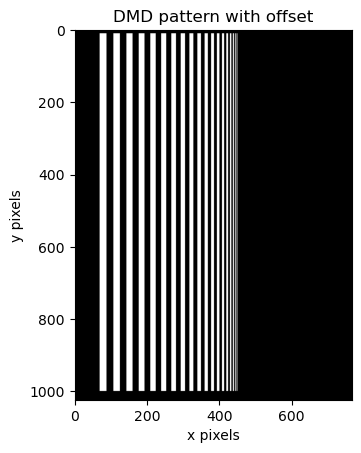

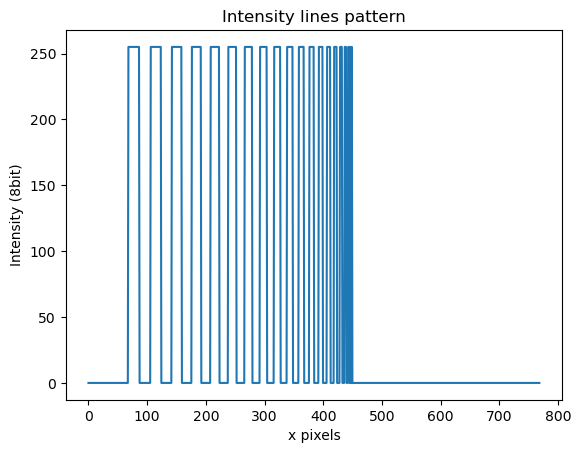

In [22]:
import numpy as np
import matplotlib.pyplot as plt

dmd_res = [1024, 768]
bitDepth = 8
x = np.linspace(0, dmd_res[1], dmd_res[1])

n = 20
rows, cols = n * 2 + 1, n * 2 + 1

start = n-1  
l = [2 * i for i in range(start, 0, -1)] + [2]
print(l)

d = list(range(start, 0, -1)) + [1]

print(d)  # largeur des rectangles (lignes)
rect_width = d
rect_heigth = 30 * np.ones(n)  # Hauteur des rectangles

maxI = 2**bitDepth - 1
I = 255 * np.ones(n)

image = np.zeros((dmd_res[0], dmd_res[1]), dtype=np.uint8)

square_size = 300
x_right_offset = 350
y_bottom_offset = 250
x_start = dmd_res[1] - x_right_offset - square_size
y_start = dmd_res[0] - y_bottom_offset - square_size

num_lines = cols // 2
rect_w = rect_width[0]
rect_h = rect_heigth[0]
total_line_width = sum(l[:num_lines - 1]) + rect_w

x_offset_lines = x_start + (square_size - total_line_width) // 2
y_offset_lines = y_start + (square_size - rows * rect_h) // 2

for c in range(cols):
    C = c // 2
    for r in range(rows):
        if c % 2 == 1:
            x1 = y_offset_lines + r * rect_h
            y1 = x_offset_lines + sum(l[:C])  # Somme des largeurs précédentes
            if x1 + rect_heigth[C] < dmd_res[0] and y1 + rect_width[C] < dmd_res[1]:
                image[int(x1):int(x1+rect_heigth[C]), int(y1):int(y1+rect_width[C])] = I[C]

plt.imshow(image, cmap="gray", vmin=0, vmax=255)
plt.title("DMD pattern with offset")
plt.xlabel("x pixels")
plt.ylabel("y pixels")
plt.show()

plt.figure()
plt.plot(x, image[dmd_res[0] - 500, :])
plt.xlabel("x pixels")
plt.ylabel("Intensity (8bit)")
plt.title("Intensity lines pattern")
plt.show()


Min pixel: 0 Max pixel: 255


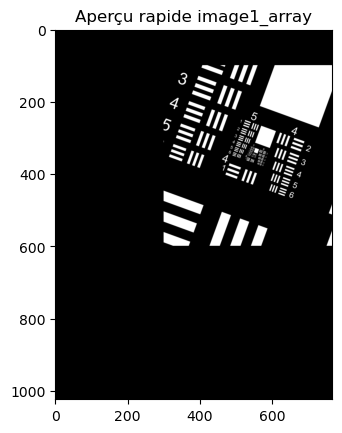

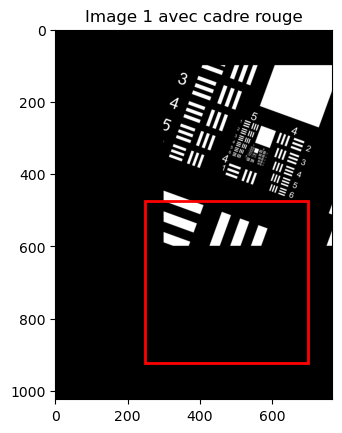

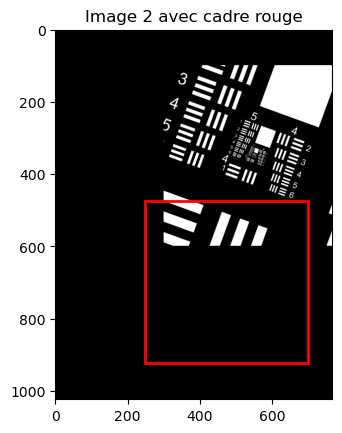

In [23]:
import io
from PIL import Image
from matplotlib.patches import Rectangle
import cairosvg
from PIL import ImageOps

#svg_path = "C:/Users/Algoscope/Downloads/7998134/USAF-1951_Thin_1px=1.5mum.svg"
png_data = "C:/Users/Algoscope/Pictures/usaf4000px.png"
#png_data = cairosvg.svg2png(url=svg_path, background_color='white', scale=3)


def pattern7(DMD, nb_frame, bitD, ExpDuration):
    bitDepth = bitD
    n_frames=nb_frame
    # Define DMD resolution
    dmd_res = (DMD.nSizeY, DMD.nSizeX) 
    
    # Load two monochrome (black and white) images
    motif = Image.open(png_data).convert("L").resize((500, 500))
    motif = Image.open(png_data).convert("L").resize((500, 500))
    #motif = Image.open(io.BytesIO(png_data)).convert("L").resize((500, 500), resample=Image.LANCZOS)
    #motif = Image.open(io.BytesIO(png_data)).convert("L").resize((500, 500), resample=Image.LANCZOS)
    motif = ImageOps.flip(motif)
    #motif = ImageOps.invert(motif)
    
    image1 = Image.new("L", (dmd_res[1], dmd_res[0]), color=0)
    image2 = Image.new("L", (dmd_res[1], dmd_res[0]), color=0)
    x_center = (dmd_res[1] - 500) // 2
    y_center = (dmd_res[0] - 500) // 2
    image1.paste(motif, (x_center, y_center))
    image2.paste(motif, (x_center, y_center))
    
    # Convert to numpy arrays and ensure 8-bit unsigned int type
    image1_array = np.array(image1, dtype=np.uint8)
    image2_array = np.array(image2, dtype=np.uint8)
    
    # Flatten and concatenate images into a single sequence
    imgSeq = np.concatenate([image1_array.ravel(), image2_array.ravel()])
    # Allocate onboard memory for 2 images
    DMD.SeqAlloc(nbImg=2, bitDepth=bitDepth)
    DMD.SeqPut(imgData=imgSeq) # Send the sequence to the DMD
    DMD.SetTiming(pictureTime=int((1/200)*10**6))
    #DMD.ProjControl(2300, 2302)
    DMD.Run()
    time.sleep(ExpDuration)
    DMD.Halt() # Stop the sequence display
    DMD.FreeSeq() # Free the sequence from the onboard memory
    DMD.Free() # De-allocate the device
    return image1_array, image2_array

#visualisation
motif = Image.open(png_data).convert("L").resize((500, 500))
motif = Image.open(png_data).convert("L").resize((500, 500))
#motif = Image.open(io.BytesIO(png_data)).convert("L").resize((500, 500))
#motif = Image.open(io.BytesIO(png_data)).convert("L").resize((500, 500))
#motif = ImageOps.invert(motif)

image1 = Image.new("L", (dmd_res[1], dmd_res[0]), color=0)
image2 = Image.new("L", (dmd_res[1], dmd_res[0]), color=0)

image1.paste(motif, (300, 100))
image2.paste(motif, (300, 100))
# Convert to numpy arrays and ensure 8-bit unsigned int type
image1_array = np.array(image1, dtype=np.uint8)
image2_array = np.array(image2, dtype=np.uint8)
print("Min pixel:", image1_array.min(), "Max pixel:", image1_array.max())
plt.imshow(image1_array, cmap='gray')
plt.title("Aperçu rapide image1_array")
plt.show()

# Taille du carré
square_size = 450

# Offsets par rapport aux bords droit et bas
x_right_offset = 69
y_bottom_offset = 100

# Coin supérieur gauche du cadre
x_start = dmd_res[1] - x_right_offset - square_size
y_start = dmd_res[0] - y_bottom_offset - square_size

# --- Affichage avec cadre rouge ---

def show_image_with_red_box(image_array, title):
    fig, ax = plt.subplots()
    ax.imshow(image_array, cmap='gray')
    # Ajouter un rectangle rouge
    rect = Rectangle((x_start, y_start), square_size, square_size,
                     linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.set_title(title)
    plt.show()

show_image_with_red_box(image1_array, "Image 1 avec cadre rouge")
show_image_with_red_box(image2_array, "Image 2 avec cadre rouge")


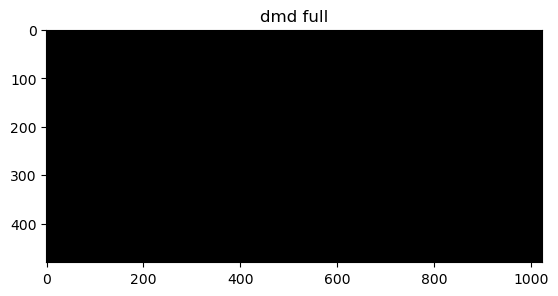

In [24]:
import numpy as np
import time
import matplotlib.pyplot as plt

def pattern8(DMD, nb_frame, bitD, ExpDuration):
    bitDepth = bitD
    dmd_res = [DMD.nSizeY, DMD.nSizeX]  # [rows, cols]
    square_size=2
    
    spacing=10
    intensity=255
    # Créer une image noire
    #image = np.zeros((dmd_res[0], dmd_res[1]), dtype=np.uint8)
    image = maxI * np.ones((dmd_res[0], dmd_res[1]), dtype=np.uint8)
    # Itérer en lignes et colonnes pour placer les carrés
    # for y in range(0, dmd_res[0] - square_size, spacing):
    #     for x in range(0, dmd_res[1] - square_size, spacing):
    #         image[y:y+square_size, x:x+square_size] = intensity

    # Étendre l'image en séquence
    imgSeq = np.tile(image.ravel(), nb_frame)
    plt.imshow(image, cmap='gray')
    plt.title("dmd full")
    plt.show()

    # Envoi au DMD
    DMD.SeqAlloc(nbImg=nb_frame, bitDepth=bitDepth)
    DMD.SeqPut(imgData=imgSeq)
    DMD.SetTiming(pictureTime=int((1/200) * 10**6))  # 5ms (200 Hz)
    DMD.Run()
    time.sleep(ExpDuration)
    DMD.Halt()
    DMD.FreeSeq()
    DMD.Free()


dmd_res = [480, 1024]  # [rows, cols]
square_size=2

spacing=10
maxI=255
# Créer une image noire
#image = np.zeros((dmd_res[0], dmd_res[1]), dtype=np.uint8)
image = maxI * np.ones((dmd_res[0], dmd_res[1]), dtype=np.uint8)
# Itérer en lignes et colonnes pour placer les carrés
# for y in range(0, dmd_res[0] - square_size, spacing):
#     for x in range(0, dmd_res[1] - square_size, spacing):
#         image[y:y+square_size, x:x+square_size] = intensity

# Étendre l'image en séquence

plt.imshow(image, cmap='gray')
plt.title("dmd full")
plt.show()

## MIX PATTERN VIZUALISATION

255
I = [255. 255.]


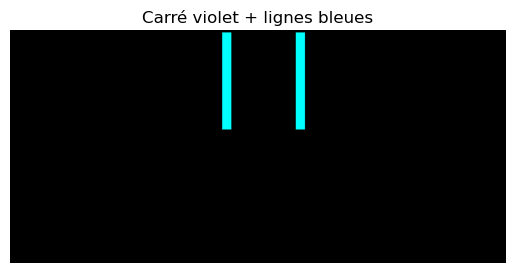

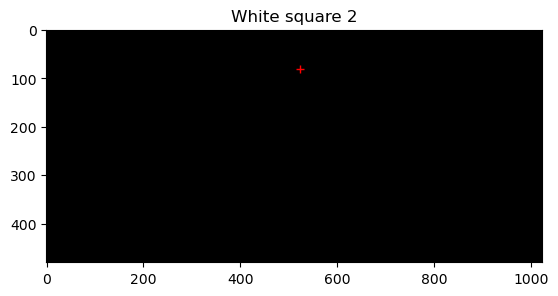

In [26]:
# --- Visualisation ---

square_size = 300
x_right_offset = 350
y_bottom_offset = 250
x_start = dmd_res[1] - x_right_offset - square_size  # col
y_start = dmd_res[0] - y_bottom_offset - square_size  # row
# Créer deux images noires
image1_array = np.zeros(dmd_res, dtype=np.uint8)
# Dessiner le carré blanc (valeur 255)
image1_array[y_start:y_start+square_size, x_start:x_start+square_size] = 255


x = np.linspace(0, dmd_res[1], dmd_res[1])
n = 2  # number of lines (intensity steps)
rows, cols = n * 2 + 1, n * 2 + 1
l=152
d=0.13*l
rect_width = d*np.ones(n)
rect_heigth = 50*np.ones(n)
maxI = 2**bitDepth - 1
print(maxI)
I=255*np.ones(n)
#I = np.linspace(maxI, 55, n).astype(np.uint8)
print("I =", I)
# Image noire de base
image = np.zeros((dmd_res[0], dmd_res[1]), dtype=np.uint8)
num_lines = cols // 2
rect_w = rect_width[0]  # assuming all widths are the same
rect_h = rect_heigth[0]
total_line_width = (num_lines - 1) * l + rect_w
x_offset_lines = x_start + (square_size - total_line_width) // 2  #centrage
total_height = rows * rect_h
y_offset_lines = y_start + (square_size - total_height) // 2  
for c in range(cols):
    C = c // 2  # index intensité
    for r in range(rows):
        if c % 2  == 1:  # colonnes impaires
            rs = y_offset_lines + r*rect_h 
            cs = x_offset_lines + (c // 2) * l
            image[int(rs):int(rs+rect_heigth[C]), int(cs):int(cs+rect_width[C])] = I[C]


image_rgb = np.zeros((dmd_res[0], dmd_res[1], 3), dtype=np.uint8)
# Bleu pour les lignes
image_rgb[:, :, 2] = image  # B ← lignes
# Rouge pour le carré
image_rgb[:, :, 1] = image1_array  # R ← carré
# Ajouter le carré aussi dans le canal bleu pour obtenir du violet
image_rgb[:, :, 1] = np.clip(image_rgb[:, :, 2] + image1_array, 0, 255)

# Affichage
plt.imshow(image_rgb)
plt.title("Carré violet + lignes bleues")
plt.axis("off")
plt.show()

plt.imshow(image1_array, cmap='gray')
plt.title("White square 2")
center_x = x_start + square_size // 2
center_y = y_start + square_size // 2
plt.plot(center_x, center_y, "r+")
plt.show()


255
I = [255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]


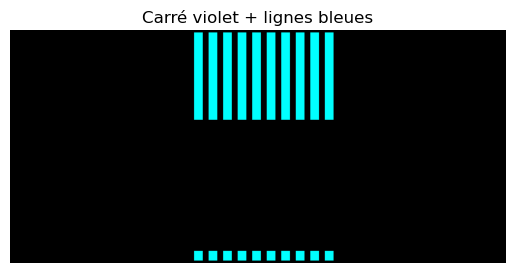

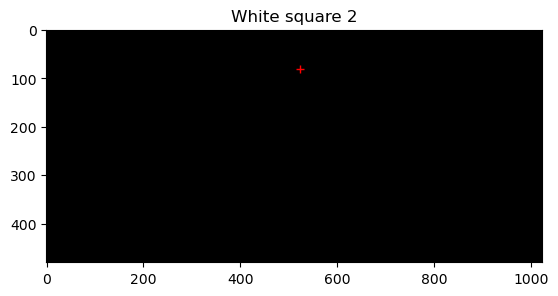

In [27]:
# --- Visualisation ---

square_size = 300
x_right_offset = 350
y_bottom_offset = 250

x_start = dmd_res[1] - x_right_offset - square_size  # col
y_start = dmd_res[0] - y_bottom_offset - square_size  # row

# Créer deux images noires
image1_array = np.zeros(dmd_res, dtype=np.uint8)

# Dessiner le carré blanc (valeur 255)
image1_array[y_start:y_start+square_size, x_start:x_start+square_size] = 255


x = np.linspace(0, dmd_res[1], dmd_res[1])
n = 10  # number of lines (intensity steps)
rows, cols = n * 2 + 1, n * 2 + 1
l=30
d=0.6*l
rect_width = d*np.ones(n)
rect_heigth = 10*np.ones(n)
maxI = 2**bitDepth - 1
print(maxI)
I=255*np.ones(n)
#I = np.linspace(maxI, 55, n).astype(np.uint8)
print("I =", I)
# Image noire de base
image = np.zeros((dmd_res[0], dmd_res[1]), dtype=np.uint8)

num_lines = cols // 2
rect_w = rect_width[0]  # assuming all widths are the same
rect_h = rect_heigth[0]
total_line_width = (num_lines - 1) * l + rect_w
x_offset_lines = x_start + (square_size - total_line_width) // 2  #centrage
total_height = rows * rect_h
y_offset_lines = y_start + (square_size - total_height) // 2  
for c in range(cols):
    C = c // 2  # index intensité
    for r in range(rows):
        if c % 2  == 1:  # colonnes impaires
            rs = y_offset_lines + r*rect_h 
            cs = x_offset_lines + (c // 2) * l
            image[int(rs):int(rs+rect_heigth[C]), int(cs):int(cs+rect_width[C])] = I[C]

image_rgb = np.zeros((dmd_res[0], dmd_res[1], 3), dtype=np.uint8)
# Bleu pour les lignes
image_rgb[:, :, 2] = image  # B ← lignes
# Rouge pour le carré
image_rgb[:, :, 1] = image1_array  # R ← carré
# Ajouter le carré aussi dans le canal bleu pour obtenir du violet
image_rgb[:, :, 1] = np.clip(image_rgb[:, :, 2] + image1_array, 0, 255)

# Affichage
plt.imshow(image_rgb)
plt.title("Carré violet + lignes bleues")
plt.axis("off")
plt.show()

plt.imshow(image1_array, cmap='gray')
plt.title("White square 2")
center_x = x_start + square_size // 2
center_y = y_start + square_size // 2
plt.plot(center_x, center_y, "r+")
plt.show()


255
I = [255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255.]


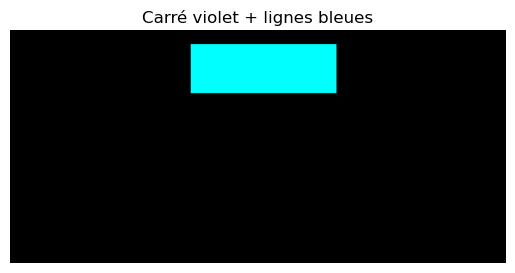

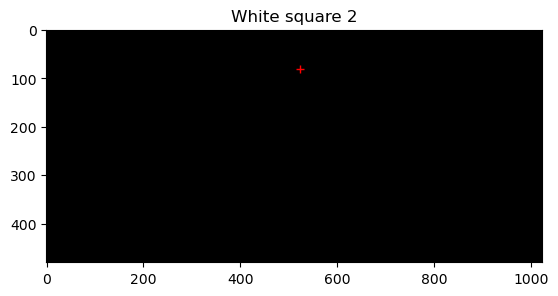

In [28]:
# --- Visualisation ---

square_size = 300
x_right_offset = 350
y_bottom_offset = 250

x_start = dmd_res[1] - x_right_offset - square_size  # col
y_start = dmd_res[0] - y_bottom_offset - square_size  # row

# Créer deux images noires
image1_array = np.zeros(dmd_res, dtype=np.uint8)

# Dessiner le carré blanc (valeur 255)
image1_array[y_start:y_start+square_size, x_start:x_start+square_size] = 255


x = np.linspace(0, dmd_res[1], dmd_res[1])
n = 50  # number of lines (intensity steps)
rows, cols = n * 2 + 1, n * 2 + 1
l=6
d=1.3*l
rect_width = d*np.ones(n)
rect_heigth = 1*np.ones(n)
maxI = 2**bitDepth - 1
print(maxI)
I=255*np.ones(n)
#I = np.linspace(maxI, 55, n).astype(np.uint8)
print("I =", I)
# Image noire de base
image = np.zeros((dmd_res[0], dmd_res[1]), dtype=np.uint8)

num_lines = cols // 2
rect_w = rect_width[0]  # assuming all widths are the same
rect_h = rect_heigth[0]
total_line_width = (num_lines - 1) * l + rect_w
x_offset_lines = x_start + (square_size - total_line_width) // 2  #centrage
total_height = rows * rect_h
y_offset_lines = y_start + (square_size - total_height) // 2  
for c in range(cols):
    C = c // 2  # index intensité
    for r in range(rows):
        if c % 2  == 1:  # colonnes impaires
            rs = y_offset_lines + r*rect_h 
            cs = x_offset_lines + (c // 2) * l
            image[int(rs):int(rs+rect_heigth[C]), int(cs):int(cs+rect_width[C])] = I[C]

image_rgb = np.zeros((dmd_res[0], dmd_res[1], 3), dtype=np.uint8)
# Bleu pour les lignes
image_rgb[:, :, 2] = image  # B ← lignes
# Rouge pour le carré
image_rgb[:, :, 1] = image1_array  # R ← carré
# Ajouter le carré aussi dans le canal bleu pour obtenir du violet
image_rgb[:, :, 1] = np.clip(image_rgb[:, :, 2] + image1_array, 0, 255)

# Affichage
plt.imshow(image_rgb)
plt.title("Carré violet + lignes bleues")
plt.axis("off")
plt.show()

plt.imshow(image1_array, cmap='gray')
plt.title("White square 2")
center_x = x_start + square_size // 2
center_y = y_start + square_size // 2
plt.plot(center_x, center_y, "r+")
plt.show()


## RUN THREADING

In [30]:
# import time
# def DAQ2():
    
# if DAQ_Active == 1:
#     DAQ2()

In [ ]:
import threading
Exp_Duration=100000


#thread1 = threading.Thread(target=lambda: pattern1(DMD1,30,1,8,20)) #DMD, nb_frame, sinfreq, bitD, ExpDuration)
thread1 = threading.Thread(target=lambda: pattern4(DMD1, 30, 8, Exp_Duration)) #DMD, nb_frame, bitD, ExpDuration
#thread2 = threading.Thread(target=lambda: pattern1(DMD2,1,int((1/200)*10**6),8,20)) #DMD, number of frame, frame time, bitdepth 1 to 12, duration in s
thread2 = threading.Thread(target=lambda: pattern5(DMD2, 30, 8, Exp_Duration)) #DMD, nb_frame, bitD, ExpDuration

# Lancer les threads
thread1.start()
thread2.start()

# Attendre la fin des deux
thread1.join()
thread2.join()

In [ ]:
def DAQ3():
    status, curr_count, curr_index = ul.get_status(0, FunctionType.AIFUNCTION)
    print("ok1")
    while status != Status.IDLE:
        status, curr_count, curr_index = ul.get_status(0, FunctionType.AIFUNCTION)
    print("ok2")
    
    #Stop clock pulse
    ul.pulse_out_stop(0, 0)
    
    ##### Clear DAQ Buffer and Stop Output Mode
    ul.win_buf_free(memhandle_O)
    ul.stop_background(0, FunctionType.DAQOFUNCTION)
    
    ##### Set Analog and Digital Outputs to 0
    #Analog
    ul.v_out(0, 0, ULRange.BIP10VOLTS, 0)
    ul.v_out(0, 1, ULRange.BIP10VOLTS, 0)

if DAQ_Active == 1:
    DAQ3()